## Predicting Customer Spend 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Load Data

In [2]:
df = pd.read_csv('df_wrangled.csv', index_col = 'CustomerID')

In [3]:
df.head()

,2010_customer_spend,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_spend_per_order,2011_customer_spend
CustomerID,,,,,,
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12370.0,1868.02,16.0,13.0,2.0,934.01,1677.67
12377.0,1001.52,10.0,10.0,1.0,1001.52,626.60
12383.0,600.72,8.0,8.0,1.0,600.72,1249.84


### Data Exploration

#### Distribution of Features

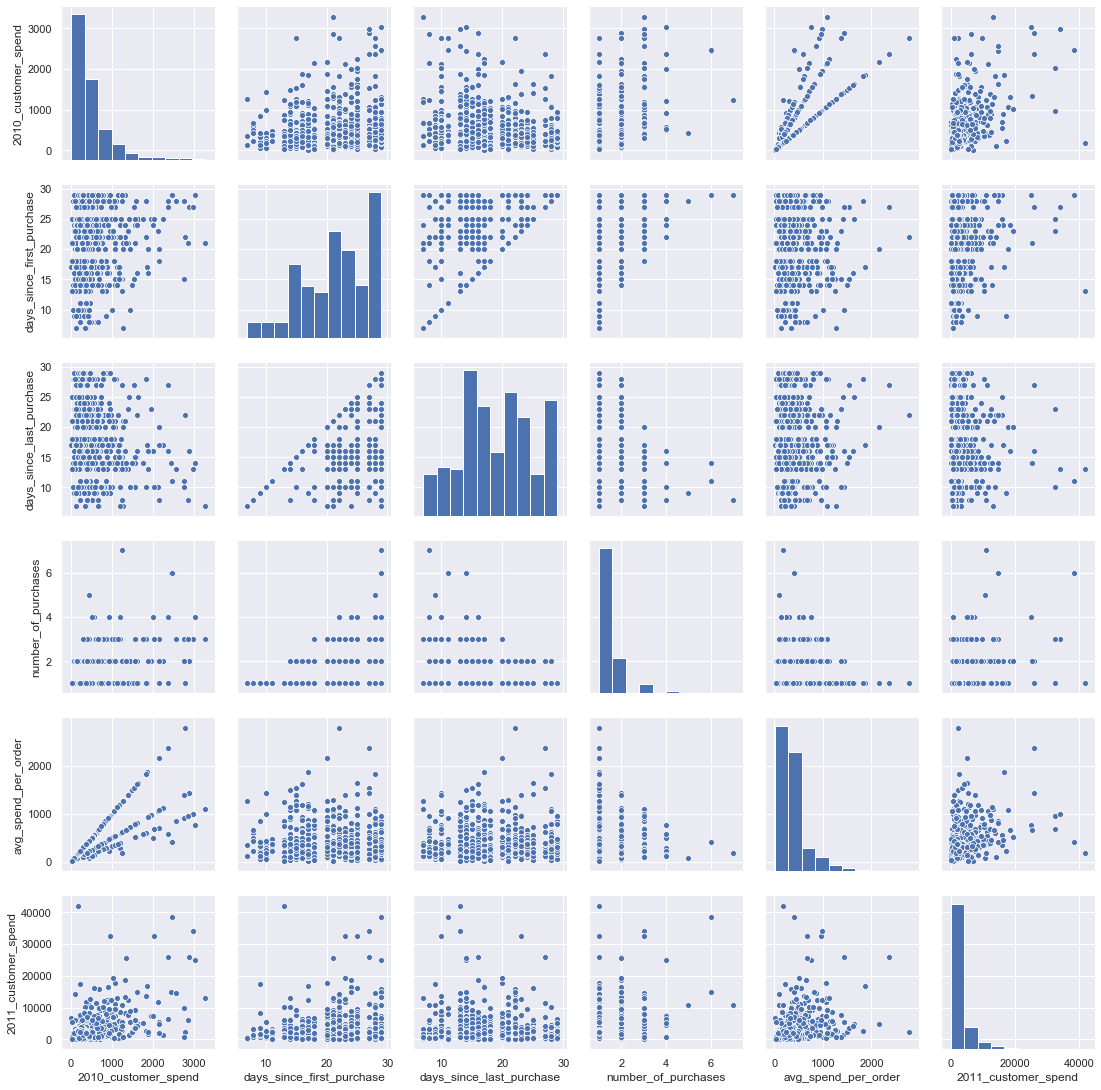

In [4]:
sns.pairplot(df)

#### Relationship between Features through correlation matrix

In [5]:
df.corr()

,2010_customer_spend,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_spend_per_order,2011_customer_spend
2010_customer_spend,1.000000,0.109692,-0.254964,0.504438,0.779401,0.548234
days_since_first_purchase,0.109692,1.000000,0.641574,0.327502,-0.074321,0.061743
days_since_last_purchase,-0.254964,0.641574,1.000000,-0.398268,-0.054051,-0.171294
number_of_purchases,0.504438,0.327502,-0.398268,1.000000,-0.012466,0.355751
avg_spend_per_order,0.779401,-0.074321,-0.054051,-0.012466,1.000000,0.357384
2011_customer_spend,0.548234,0.061743,-0.171294,0.355751,0.357384,1.000000


### Data Modelling 

In [6]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats.stats import pearsonr
from sklearn.tree import DecisionTreeRegressor


# Algorithms

def linear_reg():
    reg = LinearRegression()
    return reg

def ridge_reg():
    rid = Ridge()
    return rid

def lasso_reg():
    las = Lasso()
    return las

def decisionTreeRegressor():
    dtr = DecisionTreeRegressor(max_depth=4)
    return dtr

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators =100, max_features = 'auto', verbose = 1, n_jobs = 1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators = 100, max_features = 'log2', verbose = 1)
    return clf

def xg():
    xg = XGBRegressor()
    return xg

def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def svm():
    clf = SVR(kernel = 'rbf', gamma = 'auto')
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,), activation = 'relu', verbose = 3)
    return clf


def predict_(m,test_x):
    return pd.Series(m.predict(test_x))

def model_(modelfn_name):
    return modelfn_name()
    
def train_(train_x, train_y,modelfn_name):
    m = model_(modelfn_name)
    m.fit(train_x,train_y)
    return m

def train_and_predict(train_x, train_y, test_x,modelfn_name):
    m = train_(train_x,train_y,modelfn_name)
    return predict_(m,test_x), m

def calculate_error(test_y,predicted):
    # Print out the MAE, MSE & RMSE
    metrics = {}
    metrics["MAE"] = mean_absolute_error(test_y, predicted) #MAE
    metrics["MSE"] = mean_squared_error(test_y, predicted) #MSE
    metrics["RMSE"] = np.sqrt(mean_squared_error(test_y, predicted)) #RMSE
    metrics["R2"] = r2_score(test_y, predicted)# RSquared
    metrics['Pearsonr'] = (round(pearsonr(predicted,test_y)[0],4),round(pearsonr(predicted,test_y)[1],4))
    return metrics

In [7]:
df = df.reset_index()
df = df.drop(columns = ['CustomerID'])

In [8]:
# Perform K-fold cross validation

kfold_validation = KFold(n_splits = 5) 

fold = 0
for train_idx, test_idx in kfold_validation.split(df):
    df.loc[test_idx,'fold'] = fold
    fold+=1

In [9]:
# Run data through all the models and collect metrics for evaluation
list_of_models = [linear_reg,ridge_reg,lasso_reg,
                  decisionTreeRegressor,extraTreesRegressor,randomForestRegressor,
                  xg,knn,svm,nn]
names = ['Linear_Regression','Ridge_Regression','Lasso_Regression',
         'Decision Tree Regressor','Extra Trees Regressor','Random Forest Regressor',
         'XGBoost','KNN Regressor','SVM Regressor','Neuralnets_MLP']

metrics_df = pd.DataFrame()
c=0
for modelname in list_of_models:
    best_model = None
    error_value = 0
    best_error = np.iinfo(np.int32).max

    for fold in range(5):
        dataset_train = df.loc[df['fold'] != fold]
        dataset_test = df.loc[df['fold'] == fold]
        train_y = dataset_train['2011_customer_spend']
        train_x = dataset_train.drop(columns=['2011_customer_spend', 'fold'])
        test_y = dataset_test['2011_customer_spend']
        test_x = dataset_test.drop(columns=['2011_customer_spend', 'fold'])
        predicted, model = train_and_predict(train_x, train_y, test_x,modelname)
        error = calculate_error(test_y, predicted)
        error_value += error['MAE']
        print(fold, error)
        print('----------------------------')
        if error['MAE'] < best_error:
            print('Find best model')
            best_error = error['MAE']
            best_model = model
    error_value /= 5

    print(best_error)
    metrics_df = metrics_df.append(pd.DataFrame.from_dict([error]).rename(index = {0:names[c]}))
    print(metrics_df)
    c+=1
    

0 {'MAE': 2583.5489120507336, 'MSE': 24274516.91570282, 'RMSE': 4926.917587671101, 'R2': 0.1761958122266154, 'Pearsonr': (0.4512, 0.0)}
----------------------------
Find best model
1 {'MAE': 1588.0662055887215, 'MSE': 5875961.020515385, 'RMSE': 2424.0381639972966, 'R2': 0.5063009479606502, 'Pearsonr': (0.7181, 0.0)}
----------------------------
Find best model
2 {'MAE': 2358.5091149961036, 'MSE': 16323478.243489116, 'RMSE': 4040.2324491901595, 'R2': 0.30075329473010726, 'Pearsonr': (0.5569, 0.0)}
----------------------------
3 {'MAE': 1815.5009687788774, 'MSE': 9708226.90956561, 'RMSE': 3115.8027712879407, 'R2': 0.2312959585083848, 'Pearsonr': (0.4937, 0.0)}
----------------------------
4 {'MAE': 2122.4314807509413, 'MSE': 14220208.924439142, 'RMSE': 3770.9692287844437, 'R2': 0.3510868567765507, 'Pearsonr': (0.6064, 0.0)}
----------------------------
1588.0662055887215
                           MAE           MSE         RMSE        R2  \
Linear_Regression  2122.431481  1.422021e+07  3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1 {'MAE': 2093.136625675675, 'MSE': 12475163.314981213, 'RMSE': 3532.019721771272, 'R2': -0.0481649352571929, 'Pearsonr': (0.6154, 0.0)}
----------------------------


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Find best model
2 {'MAE': 2882.786529054054, 'MSE': 30245512.214563873, 'RMSE': 5499.59200437304, 'R2': -0.29562305592986804, 'Pearsonr': (0.3174, 0.0001)}
----------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


3 {'MAE': 2013.4797795918366, 'MSE': 12191777.904173128, 'RMSE': 3491.6726513482226, 'R2': 0.034646693448021515, 'Pearsonr': (0.3845, 0.0)}
----------------------------
Find best model


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


4 {'MAE': 2217.013900680272, 'MSE': 13910980.431567047, 'RMSE': 3729.742676320586, 'R2': 0.36519793168059234, 'Pearsonr': (0.6044, 0.0)}
----------------------------
2013.4797795918366
                                 MAE           MSE         RMSE        R2  \
Linear_Regression        2122.431481  1.422021e+07  3770.969229  0.351087   
Ridge_Regression         2122.461425  1.422127e+07  3771.110447  0.351038   
Lasso_Regression         2122.706805  1.422959e+07  3772.212383  0.350659   
Decision Tree Regressor  2332.819901  2.213974e+07  4705.288477 -0.010306   
Extra Trees Regressor    2217.013901  1.391098e+07  3729.742676  0.365198   

                              Pearsonr  
Linear_Regression        (0.6064, 0.0)  
Ridge_Regression         (0.6064, 0.0)  
Lasso_Regression          (0.606, 0.0)  
Decision Tree Regressor  (0.3473, 0.0)  
Extra Trees Regressor    (0.6044, 0.0)  


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0 {'MAE': 2659.691251351351, 'MSE': 25678870.82454571, 'RMSE': 5067.4323700021605, 'R2': 0.1285362589906741, 'Pearsonr': (0.419, 0.0)}
----------------------------
Find best model
1 {'MAE': 1897.078461486486, 'MSE': 8922080.635251433, 'RMSE': 2986.9852084085437, 'R2': 0.2503655595292016, 'Pearsonr': (0.6183, 0.0)}
----------------------------
Find best model


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


2 {'MAE': 2624.9546817567566, 'MSE': 21169251.737513427, 'RMSE': 4601.005513745167, 'R2': 0.09317552854340694, 'Pearsonr': (0.4269, 0.0)}
----------------------------
3 {'MAE': 1923.744806122449, 'MSE': 11259159.054880638, 'RMSE': 3355.4670397547698, 'R2': 0.10849209130496917, 'Pearsonr': (0.4015, 0.0)}
----------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


4 {'MAE': 2196.592358503401, 'MSE': 14959846.05424153, 'RMSE': 3867.796020247388, 'R2': 0.3173348734340298, 'Pearsonr': (0.5636, 0.0)}
----------------------------
1897.078461486486
                                 MAE           MSE         RMSE        R2  \
Linear_Regression        2122.431481  1.422021e+07  3770.969229  0.351087   
Ridge_Regression         2122.461425  1.422127e+07  3771.110447  0.351038   
Lasso_Regression         2122.706805  1.422959e+07  3772.212383  0.350659   
Decision Tree Regressor  2332.819901  2.213974e+07  4705.288477 -0.010306   
Extra Trees Regressor    2217.013901  1.391098e+07  3729.742676  0.365198   
Random Forest Regressor  2196.592359  1.495985e+07  3867.796020  0.317335   

                              Pearsonr  
Linear_Regression        (0.6064, 0.0)  
Ridge_Regression         (0.6064, 0.0)  
Lasso_Regression          (0.606, 0.0)  
Decision Tree Regressor  (0.3473, 0.0)  
Extra Trees Regressor    (0.6044, 0.0)  
Random Forest Regressor  (0.5636

Iteration 66, loss = 9589758.73358651
Iteration 67, loss = 9547433.33486017
Iteration 68, loss = 9504398.53788218
Iteration 69, loss = 9464659.62434123
Iteration 70, loss = 9425355.59337706
Iteration 71, loss = 9381348.07300022
Iteration 72, loss = 9342098.37521769
Iteration 73, loss = 9299299.28209907
Iteration 74, loss = 9266852.37351467
Iteration 75, loss = 9223115.47053588
Iteration 76, loss = 9183220.36061308
Iteration 77, loss = 9143917.37282135
Iteration 78, loss = 9105053.84815520
Iteration 79, loss = 9068756.79404708
Iteration 80, loss = 9027958.75668856
Iteration 81, loss = 8994022.53842775
Iteration 82, loss = 8951837.41309382
Iteration 83, loss = 8914149.80572286
Iteration 84, loss = 8879839.10945113
Iteration 85, loss = 8842919.54700323
Iteration 86, loss = 8806628.36650778
Iteration 87, loss = 8768383.44063321
Iteration 88, loss = 8730792.74108710
Iteration 89, loss = 8696056.70108105
Iteration 90, loss = 8663347.57862650
Iteration 91, loss = 8624394.52884842
Iteration 92

C:\Users\Sonia\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 15835829.51552788
Iteration 2, loss = 15814633.42277915
Iteration 3, loss = 15792150.95816103
Iteration 4, loss = 15769474.18569023
Iteration 5, loss = 15746437.24589092
Iteration 6, loss = 15724008.83126922
Iteration 7, loss = 15700136.60383687
Iteration 8, loss = 15677568.98310935
Iteration 9, loss = 15651498.06388876
Iteration 10, loss = 15627407.01496674
Iteration 11, loss = 15601792.17287083
Iteration 12, loss = 15578579.53492142
Iteration 13, loss = 15553920.79954563
Iteration 14, loss = 15529121.43569208
Iteration 15, loss = 15505836.72097435
Iteration 16, loss = 15480843.23505178
Iteration 17, loss = 15455688.97633369
Iteration 18, loss = 15433195.62888519
Iteration 19, loss = 15408419.92127318
Iteration 20, loss = 15383428.75129179
Iteration 21, loss = 15358730.29271876
Iteration 22, loss = 15333132.85773771
Iteration 23, loss = 15308200.49399699
Iteration 24, loss = 15280729.65249864
Iteration 25, loss = 15256587.11955005
Iteration 26, loss = 15229308.2622

C:\Users\Sonia\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 69, loss = 12717270.76328806
Iteration 70, loss = 12678897.35548133
Iteration 71, loss = 12641807.90709635
Iteration 72, loss = 12600543.98080012
Iteration 73, loss = 12556910.53190006
Iteration 74, loss = 12517812.55411598
Iteration 75, loss = 12474007.66810529
Iteration 76, loss = 12434436.09141522
Iteration 77, loss = 12387339.11689194
Iteration 78, loss = 12342851.94995002
Iteration 79, loss = 12300606.22582873
Iteration 80, loss = 12251216.73315188
Iteration 81, loss = 12206809.50611863
Iteration 82, loss = 12161680.99444778
Iteration 83, loss = 12115407.19468042
Iteration 84, loss = 12062592.70354350
Iteration 85, loss = 12014887.42290250
Iteration 86, loss = 11969232.00494398
Iteration 87, loss = 11917356.83623733
Iteration 88, loss = 11869073.75853716
Iteration 89, loss = 11818721.03866871
Iteration 90, loss = 11768427.32361508
Iteration 91, loss = 11717110.62171608
Iteration 92, loss = 11665928.73172001
Iteration 93, loss = 11615328.35418711
Iteration 94, loss = 1155

C:\Users\Sonia\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 8, loss = 15741533.71162324
Iteration 9, loss = 15732422.11497585
Iteration 10, loss = 15722939.78782328
Iteration 11, loss = 15712555.61374465
Iteration 12, loss = 15700919.21272740
Iteration 13, loss = 15690003.78714751
Iteration 14, loss = 15678632.05545345
Iteration 15, loss = 15667067.31525383
Iteration 16, loss = 15655117.44027219
Iteration 17, loss = 15642472.53155617
Iteration 18, loss = 15630367.28686571
Iteration 19, loss = 15617488.18279688
Iteration 20, loss = 15604735.79396673
Iteration 21, loss = 15591259.92049970
Iteration 22, loss = 15579298.77818352
Iteration 23, loss = 15565412.71425286
Iteration 24, loss = 15551927.41150803
Iteration 25, loss = 15538478.95070686
Iteration 26, loss = 15523426.23225021
Iteration 27, loss = 15508788.83037227
Iteration 28, loss = 15492000.65285076
Iteration 29, loss = 15475493.10723797
Iteration 30, loss = 15453524.38387071
Iteration 31, loss = 15432163.86095866
Iteration 32, loss = 15402381.14966474
Iteration 33, loss = 153754

C:\Users\Sonia\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 78, loss = 11775002.27453957
Iteration 79, loss = 11722507.75384254
Iteration 80, loss = 11670600.66203422
Iteration 81, loss = 11620932.14618903
Iteration 82, loss = 11570124.01617467
Iteration 83, loss = 11520986.96594687
Iteration 84, loss = 11472644.56931107
Iteration 85, loss = 11419699.64441430
Iteration 86, loss = 11371944.98633976
Iteration 87, loss = 11321010.89385349
Iteration 88, loss = 11275400.85197900
Iteration 89, loss = 11223637.60530243
Iteration 90, loss = 11178271.58421127
Iteration 91, loss = 11125341.92721722
Iteration 92, loss = 11080316.68223594
Iteration 93, loss = 11033216.00348088
Iteration 94, loss = 10984096.76350162
Iteration 95, loss = 10933719.62496083
Iteration 96, loss = 10892879.66074707
Iteration 97, loss = 10843937.25321432
Iteration 98, loss = 10796928.44320535
Iteration 99, loss = 10754502.51665568
Iteration 100, loss = 10704740.36945012
Iteration 101, loss = 10660755.16763124
Iteration 102, loss = 10614758.26784550
Iteration 103, loss = 

C:\Users\Sonia\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [10]:
metrics_df

,MAE,MSE,RMSE,R2,Pearsonr
Linear_Regression,2122.431481,1.422021e+07,3770.969229,0.351087,"(0.6064, 0.0)"
Ridge_Regression,2122.461425,1.422127e+07,3771.110447,0.351038,"(0.6064, 0.0)"
Lasso_Regression,2122.706805,1.422959e+07,3772.212383,0.350659,"(0.606, 0.0)"
Decision Tree Regressor,2332.819901,2.213974e+07,4705.288477,-0.010306,"(0.3473, 0.0)"
Extra Trees Regressor,2217.013901,1.391098e+07,3729.742676,0.365198,"(0.6044, 0.0)"
Random Forest Regressor,2196.592359,1.495985e+07,3867.796020,0.317335,"(0.5636, 0.0)"
XGBoost,2175.270582,1.446743e+07,3803.607431,0.339805,"(0.5867, 0.0)"
KNN Regressor,2156.940122,1.414217e+07,3760.607647,0.354648,"(0.6042, 0.0)"
SVM Regressor,2228.161923,2.336250e+07,4833.477397,-0.066105,"(0.0577, 0.4872)"
Neuralnets_MLP,1980.112615,1.757828e+07,4192.646525,0.197847,"(0.5349, 0.0)"
